In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pygraphviz as pgv
import pydot

In [5]:
edges_graph = pd.read_csv('../../Scaricati/words_edgelist_weighted.csv', header = None)
nodes_graph = pd.read_csv('../../Scaricati/words_nodelist.csv')

#do not consider last columns
all_lemmas  = pd.read_csv('../../Scaricati/LIWC2015 Results (all_lemmas.csv).csv', low_memory=False).iloc[:,:-16]
all_tokens  = pd.read_csv('../../Scaricati/LIWC2015 Results (all_tokens.csv).csv', low_memory=False).iloc[:,:-16]

attributes_to_keep = ['A', 'Emo_Pos', 'Emo_Neg', 'Ansia', 'Rabbia' ]

Keep the first column with words (A), then whether it is:
* Positive emotion
* Negative emotion
* Anxiety (Ansia)
* Anger (Rabbia)


In [6]:
tokens_filtered = all_tokens.loc[:,attributes_to_keep]
tokens_filtered

A  Emo_Pos  Emo_Neg  Ansia  Rabbia
0                    lassista      0.0      0.0    0.0     0.0
1      #mariaattivistaperugia      0.0      0.0    0.0     0.0
2                       casse      0.0      0.0    0.0     0.0
3                .assenteista      0.0      0.0    0.0     0.0
4                    tatuerei      0.0      0.0    0.0     0.0
...                       ...      ...      ...    ...     ...
64061            greenwashing      0.0      0.0    0.0     0.0
64062               prendermi      0.0      0.0    0.0     0.0
64063                 oliveti      0.0      0.0    0.0     0.0
64064                 pensera      0.0      0.0    0.0     0.0
64065                 avenger      0.0      0.0    0.0     0.0

[64066 rows x 5 columns]

* Define a function to keep the only the links according to a certain threshold to be set in the function. Moreover drop the 'x9d' or something similar tokens left from the data text filtering.
* Define a function that starting from a pandas dataframe returns a graph object
* Define a function that starting from a graph object returns an array of rescaled weights according to a rescaling factor
* Define a function that helps setting a size of the node according to its degree (everything is rescaled to a rescaling factor)
* Define a function that adds attributes to each node according to a user-predefined list that has form (word, attr1, attr2,...), returns a dataframe with it

In [7]:
def keep_threshold_words(dataframe, threshold):
    
    df = dataframe.copy()
    #keep the links over a certain threshold
    df = df[df.iloc[:,2] >= threshold]
    
    #HERE IF SENTIMENT ANALYSIS IS DONE CAN BE NEGLECTED
    #drop a row if one of the word has length equal to three and starts with an "x" since it is meaningless string
    df = df.drop(df[((df.iloc[:,0].map(len) == 3)&(df.loc[:,0].map(lambda x: x[0]) == 'x'))|
                ((df.iloc[:,1].map(len) == 3)&(df.loc[:,1].map(lambda x: x[0]) == 'x'))].index)
    
    df.rename(columns={ 0 : 'word1', 1: 'word2', 2: 'weight'}, inplace=True)
    
    return df.reset_index(drop=True)


#return a graph out of a pandas dataframe
def get_graph_from_df(dataframe):
    
    labels_attributes = list(dataframe.columns)
    G = nx.from_pandas_edgelist(dataframe, source='word1', target='word2', edge_attr = labels_attributes[2:])
    
    return G

#return an array of normalized weights according to a scale factor
def get_normalized_weights(graph, rescale_factor = 1.0):
    weights = nx.get_edge_attributes(graph,'weight').values()
    weights = rescale_factor*np.array(list(weights))/max(weights)
    return weights

#return an array for the size of the nodes according to their degree and a scale factor
def get_size_nodes(graph, rescale_factor = 10.0):
    degrees_factor = np.array([rescale_factor*val for (node, val) in graph.degree()])
    return degrees_factor


#attributes to be updated the nodes list with, skip the first column since it is the word itself
attr_list = attributes_to_keep[1:]

#return a dataframe of words/tokens plus the attributes needed
def add_attributes_to_words(dataframe, tokens_df, attributes):
    
    #get a list of whole the words (nodes)
    list_nodes = list(dataframe.word1.unique())
    
    #keep the only words that are present in the LIWC dictionary
    tokens_df = tokens_df[tokens_df.A.isin(list_nodes)].reset_index(drop = True)

    #remove duplicates (word "pd" is present more than once, for instance)
    tokens_df = tokens_df.drop_duplicates()

    #add the columns to be filled with the attributes, default value is NaN
    dataframe = dataframe.reindex(columns = dataframe.columns.tolist() + attr_list)                

    #for each word 
    for single_word in tokens_df.A:
        #find the correspondent row in the LIWC dataset
        one_row_df = tokens_df[tokens_df.A == single_word].iloc[:,1:]
        #find the correspondent rows in the edges list (the starting node is the word we look for)
        mask = dataframe['word1'] == single_word
        #substitute each of the NaN with the value of the sentiment
        for col in attr_list:
            dataframe.loc[mask,col] = float(one_row_df.loc[:,col])

    
    return dataframe

# Example of algorithm
Starting from a edges list, it gets back all the edges over a certain threshold and add attributes according either the LIWC sentiment dictionary for LEMMAS or for ALL TOKENS

In [22]:
#threshold here is set to 5
edges_graph_thresh = keep_threshold_words(edges_graph, 10)
edges_graph_thresh

word1     word2  weight
0          gente    guerra      11
1          gente      casa      75
2          gente     merda      35
3          gente    parola      48
4          gente     stare      33
...          ...       ...     ...
55751         hh      hhha      12
55752         hh     hhhha      12
55753     rivera    casado      12
55754         cb        mt      15
55755  biometano  solgesta      10

[55756 rows x 3 columns]

In [23]:
#obtain the "plain graph", only weights and nodes/edges
G = get_graph_from_df(edges_graph_thresh)
weights = get_normalized_weights(G,5.)
print("Normalized weights:", weights[:50])
size_nodes = get_size_nodes(G, 50.)
print("Size of the nodes:",size_nodes[:50])

Normalized weights: [0.05121043 0.34916201 0.16294227 0.22346369 0.15363128 0.23277467
 0.0744879  0.68435754 0.16759777 0.06517691 0.0698324  0.06517691
 0.11173184 0.12104283 0.05121043 0.15828678 0.06052142 0.17690875
 0.19087523 0.09776536 0.07914339 0.20949721 0.05586592 0.30260708
 0.22346369 0.15828678 0.33519553 0.06517691 0.29795158 0.05121043
 0.0744879  0.11638734 0.07914339 0.04655493 0.05586592 0.33985102
 0.05121043 0.0744879  0.08845438 0.08379888 0.0698324  0.06517691
 0.89385475 0.43761639 0.15363128 0.23743017 0.1396648  0.09776536
 0.05586592 0.65176909]
Size of the nodes: [22200. 12300. 26850.  4100. 13600.  5650. 18800.  8050. 83650. 17400.
  5650.  4400.  1750.  8300. 14050.  2200. 13650.  2400. 14000. 12300.
  3050.  7250. 16750. 11750. 17550. 13400.  6000. 19400.   900. 24950.
   200.  6350.  2100.  2100.  1250.  2050. 15750.  1950.  3300.  4150.
  1900.   850.  2750. 70400. 32750.  9600. 29450.  7100.  7250.  2050.]


In [24]:
#creates a dataframe with edges that are normalized for a better Gephi using
edges_df = pd.DataFrame()
edges_df["word1"]  = edges_graph_thresh["word1"]
edges_df["word2"]  = edges_graph_thresh["word2"]
edges_df["weight"] = weights
edges_df

word1     word2    weight
0          gente    guerra  0.051210
1          gente      casa  0.349162
2          gente     merda  0.162942
3          gente    parola  0.223464
4          gente     stare  0.153631
...          ...       ...       ...
55751         hh      hhha  0.046555
55752         hh     hhhha  0.051210
55753     rivera    casado  0.051210
55754         cb        mt  0.228119
55755  biometano  solgesta  0.181564

[55756 rows x 3 columns]

In [25]:
#export to a csv file
edges_df.to_csv('weighted_edges_list.csv', index = False)

In [26]:
#more complete graph with attributes
attr_list = attributes_to_keep[1:]
dataframe_attr = add_attributes_to_words(edges_graph_thresh,all_lemmas,attr_list)
G_attr     = get_graph_from_df(dataframe_attr)
weights    = get_normalized_weights(G_attr,5.)
size_nodes = get_size_nodes(G_attr, 50.)

dataframe_attr

word1     word2  weight  Emo_Pos  Emo_Neg  Ansia  Rabbia
0          gente    guerra      11      0.0      0.0    0.0     0.0
1          gente      casa      75      0.0      0.0    0.0     0.0
2          gente     merda      35      0.0      0.0    0.0     0.0
3          gente    parola      48      0.0      0.0    0.0     0.0
4          gente     stare      33      0.0      0.0    0.0     0.0
...          ...       ...     ...      ...      ...    ...     ...
55751         hh      hhha      12      0.0      0.0    0.0     0.0
55752         hh     hhhha      12      0.0      0.0    0.0     0.0
55753     rivera    casado      12      0.0      0.0    0.0     0.0
55754         cb        mt      15      0.0      0.0    0.0     0.0
55755  biometano  solgesta      10      0.0      0.0    0.0     0.0

[55756 rows x 7 columns]

In [31]:
dataframe_attr_to_csv = dataframe_attr.drop('weight', 1)
dataframe_attr_to_csv = dataframe_attr.drop('word2', 1)
dataframe_attr_to_csv

word1     word2  Emo_Pos  Emo_Neg  Ansia  Rabbia
0          gente    guerra      0.0      0.0    0.0     0.0
1          gente      casa      0.0      0.0    0.0     0.0
2          gente     merda      0.0      0.0    0.0     0.0
3          gente    parola      0.0      0.0    0.0     0.0
4          gente     stare      0.0      0.0    0.0     0.0
...          ...       ...      ...      ...    ...     ...
55751         hh      hhha      0.0      0.0    0.0     0.0
55752         hh     hhhha      0.0      0.0    0.0     0.0
55753     rivera    casado      0.0      0.0    0.0     0.0
55754         cb        mt      0.0      0.0    0.0     0.0
55755  biometano  solgesta      0.0      0.0    0.0     0.0

[55756 rows x 6 columns]

In [32]:
#code to export dataframe with attributes
dataframe_attr_to_csv.to_csv('nodes_attributes_list.csv', index=False)

# NEXT ARE GRAPHS USING

* Threshold = 100
* Threshold = 150
* Threshold = 100

Functions implemented above are NOT used, since the pictures below are "old" and repeated code, nonetheless is correct. Different graphviz algorithms/programs are used. Moreover no attribute is added to graphs.

# Threshold = 100

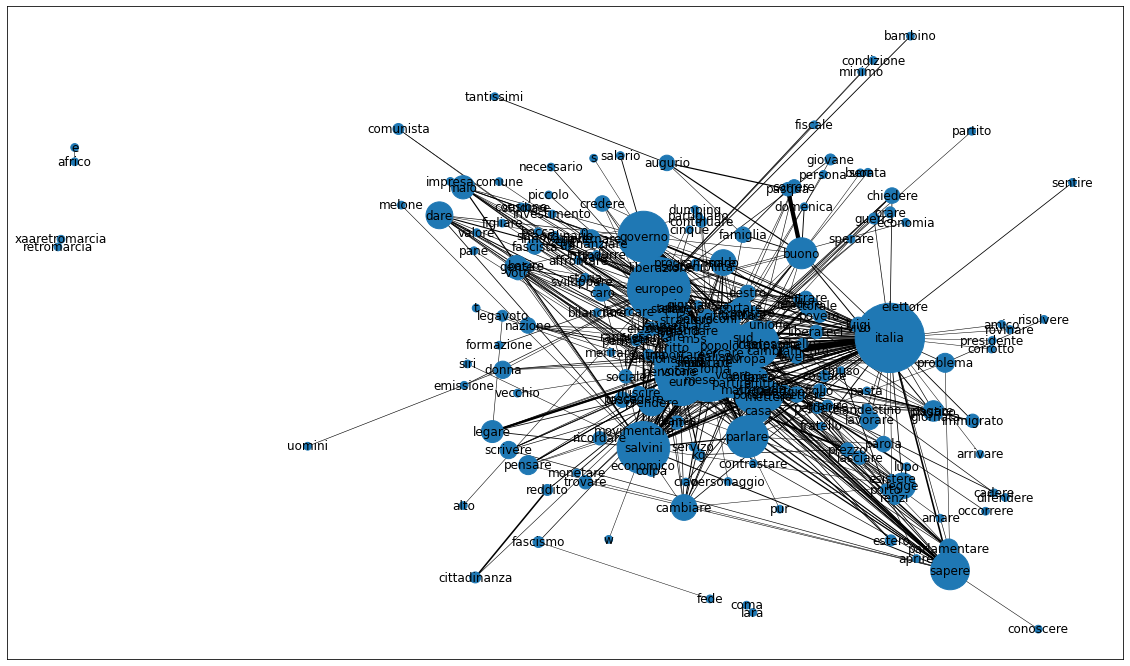

In [8]:
layout = nx.spring_layout(G, iterations = 5, seed = 7)

# layout = nx.draw_spectral(G)
fig = plt.figure(figsize = (20,12))
nx.draw_networkx(G, layout, width = list(weights), node_size = degrees)

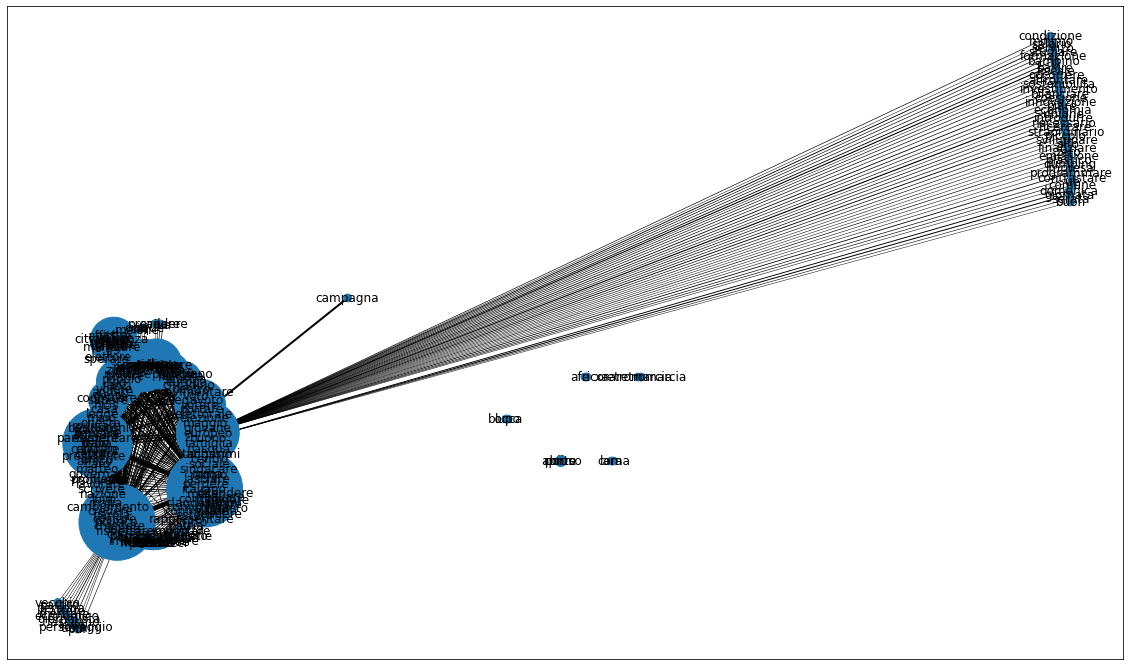

In [9]:
fig = plt.figure(figsize = (20,12))

pgv_Graph = nx.nx_agraph.to_agraph(G)
pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='circo')
nx.draw_networkx(G, pos, width = list(weights), node_size = degrees)


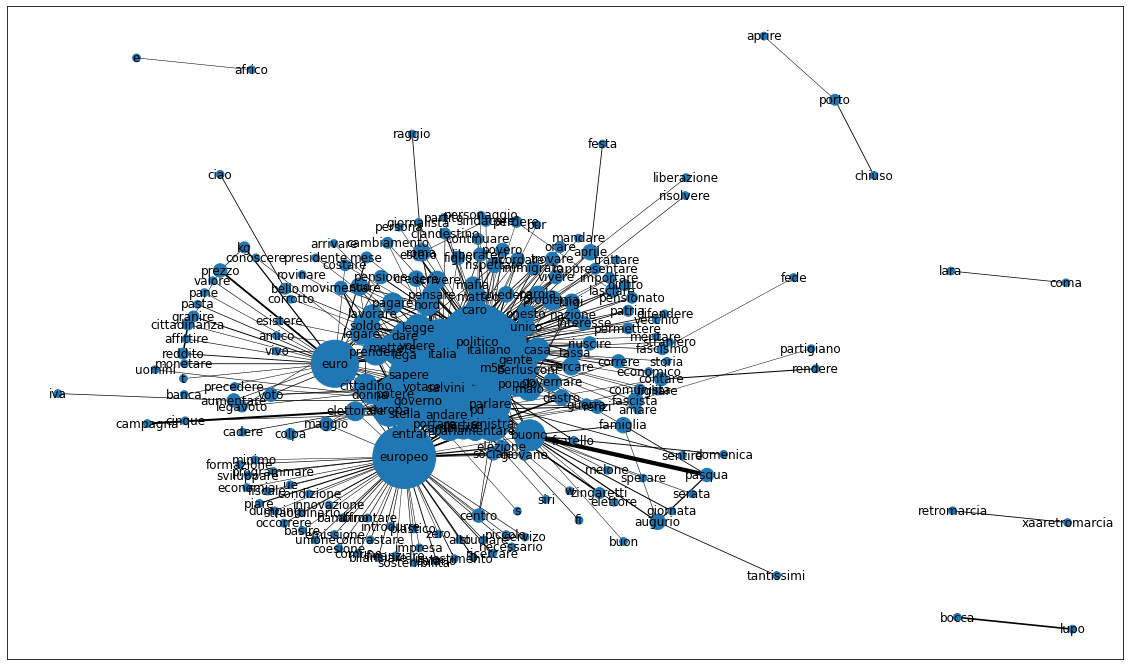

In [10]:
fig = plt.figure(figsize = (20,12))

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='neato')
nx.draw_networkx(G, pos, width = list(weights), node_size = degrees)

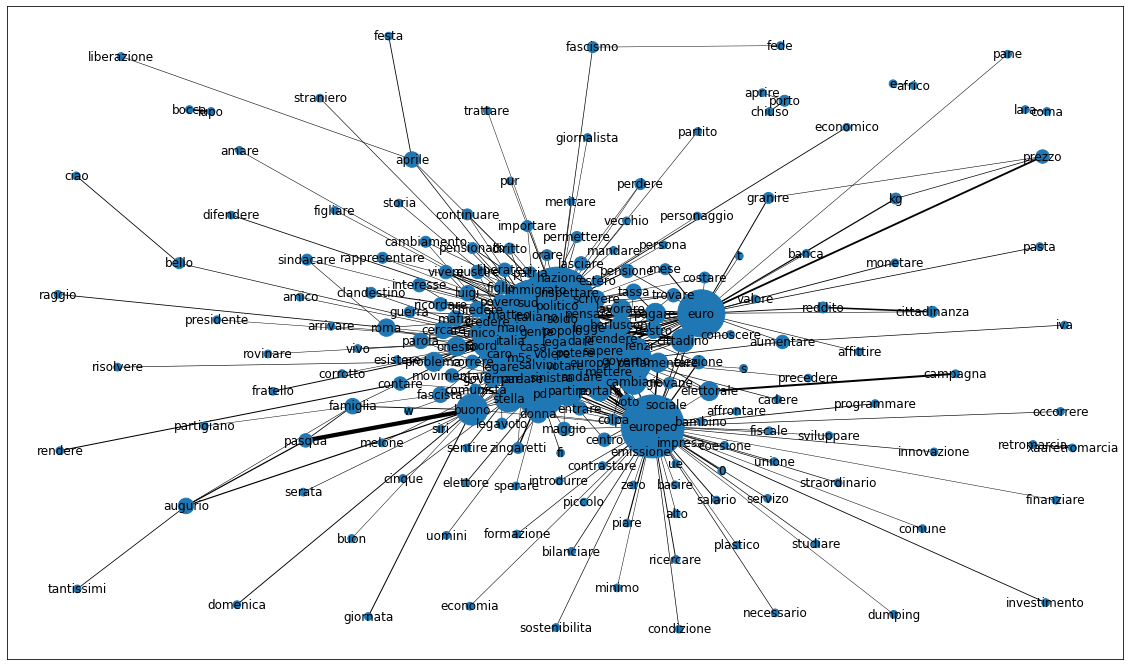

In [11]:
fig = plt.figure(figsize = (20,12))

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='fdp')
nx.draw_networkx(G, pos, width = list(weights), node_size = degrees)

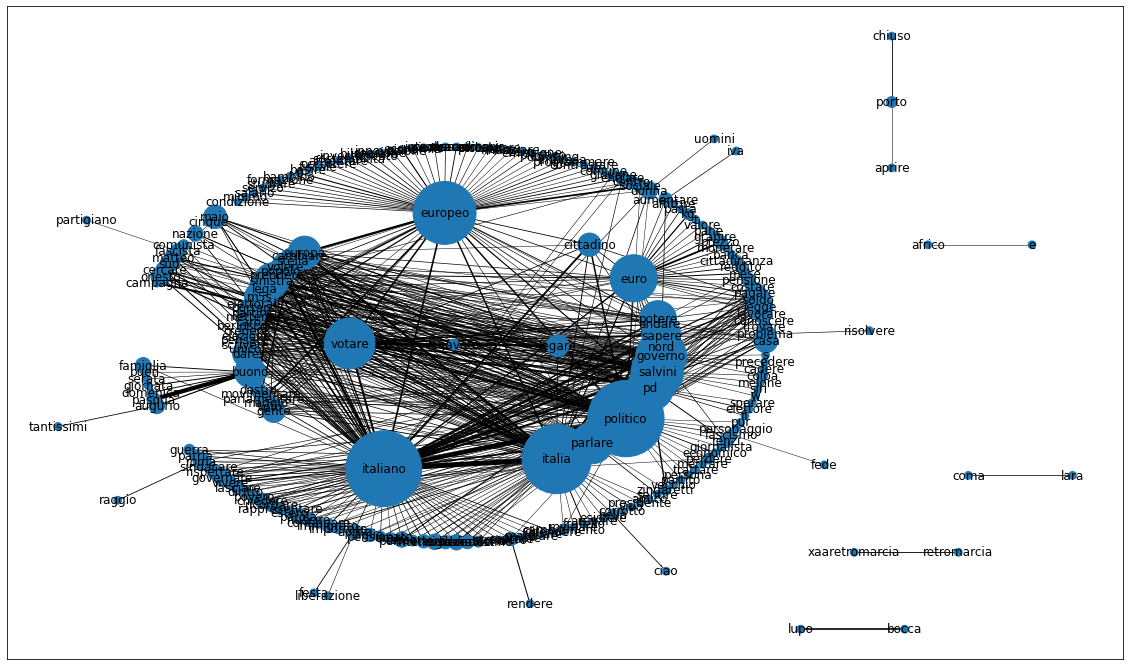

In [12]:
fig = plt.figure(figsize = (20,12))

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='twopi')
nx.draw_networkx(G, pos, width = list(weights), node_size = degrees)

# Threshold 150

In [13]:
edges_graph_thresh = edges_graph[edges_graph.iloc[:,2] >= 150]
edges_graph_thresh.columns= ['word1', 'word2', "weight"]

G = nx.Graph()
G = nx.from_pandas_edgelist(edges_graph_thresh, source='word1', target='word2', edge_attr = "weight") 

In [14]:
edges_graph_thresh = edges_graph_thresh.drop(edges_graph_thresh
                                             [((edges_graph_thresh.loc[:,'word1'].map(len) == 3) & 
                                               (edges_graph_thresh.loc[:,'word1'].map(lambda x: x[0]) == 'x'))|
                                              ((edges_graph_thresh.loc[:,'word2'].map(len) == 3) & 
                                               (edges_graph_thresh.loc[:,'word2'].map(lambda x: x[0]) == 'x'))].index)
edges_graph_thresh

word1           word2  weight
91             gente          italia     192
131            gente        politico     158
11056           casa        italiano     228
18471         patria        italiano     175
24202           roma          raggio     172
...              ...             ...     ...
1372371       pasqua         augurio     261
1486746         maio           luigi     161
1858502       aprile           festa     175
1948823         lara            coma     156
2224745  retromarcia  xaaretromarcia     184

[268 rows x 3 columns]

In [47]:
G = nx.Graph()
G = nx.from_pandas_edgelist(edges_graph_thresh, source='word1', target='word2', edge_attr = "weight") 

weights = nx.get_edge_attributes(G,'weight').values()
weights = 5*np.array(list(weights))/max(weights)
degrees = [60*val for (node, val) in G.degree()]

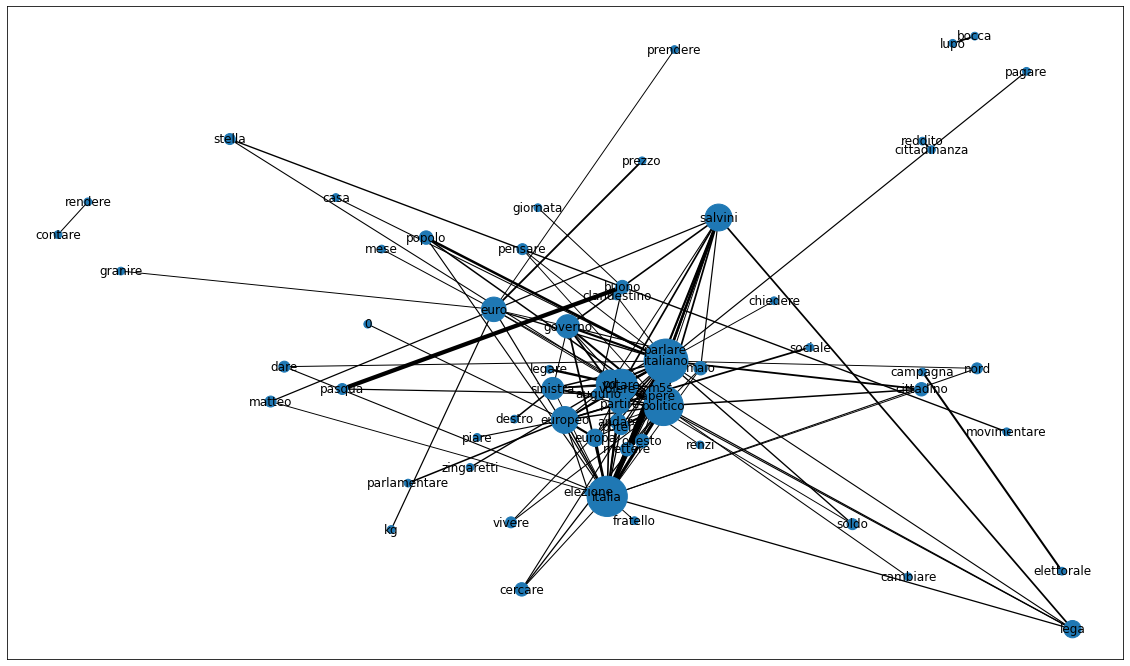

In [48]:
layout = nx.spring_layout(G, iterations = 5, seed = 7)

# layout = nx.draw_spectral(G)
fig = plt.figure(figsize = (20,12))
nx.draw_networkx(G, layout, width = list(weights), node_size = degrees)


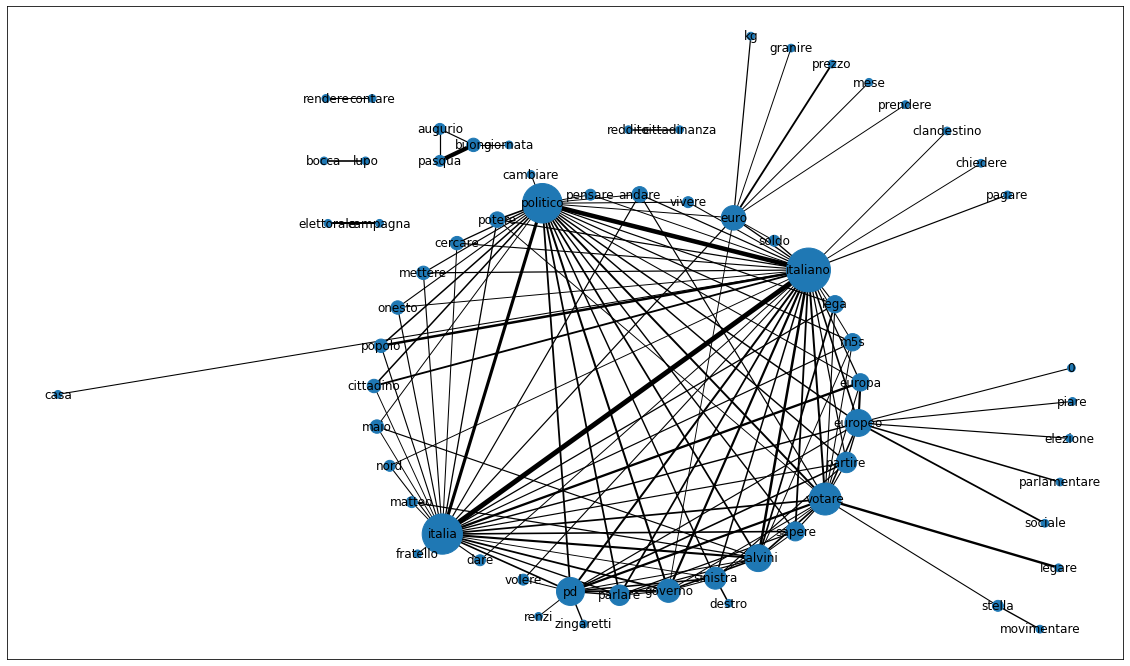

In [49]:
fig = plt.figure(figsize = (20,12))

pgv_Graph = nx.nx_agraph.to_agraph(G)
pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='circo')
nx.draw_networkx(G, pos, width = list(weights), node_size = degrees)


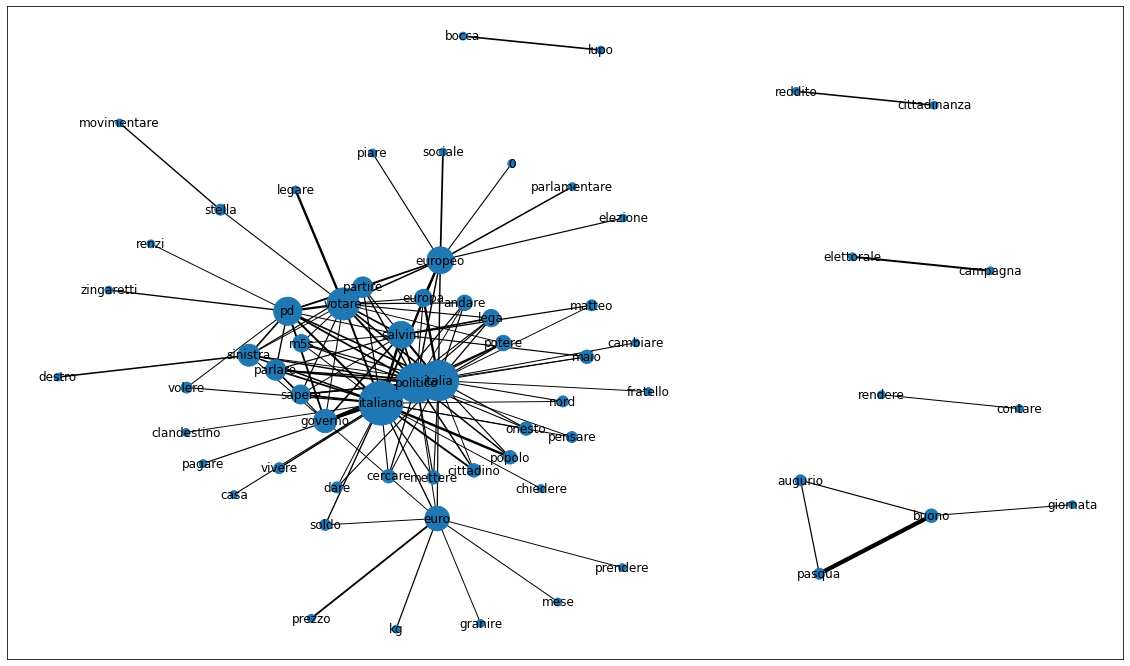

In [50]:
fig = plt.figure(figsize = (20,12))

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='neato')
nx.draw_networkx(G, pos, width = list(weights), node_size = degrees)

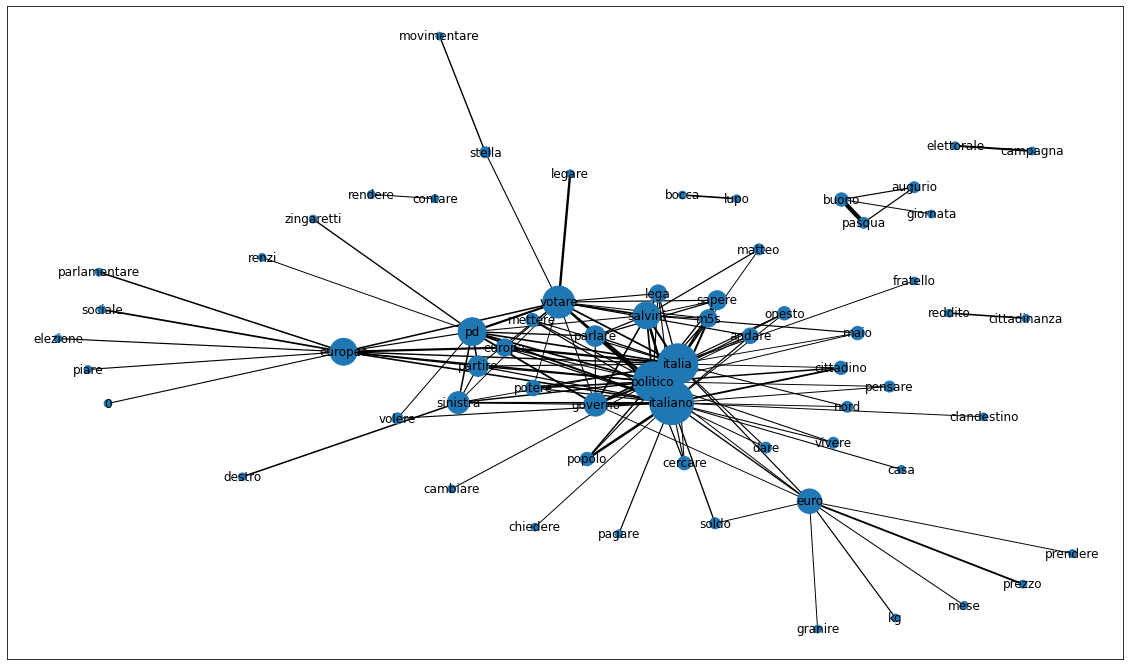

In [51]:
fig = plt.figure(figsize = (20,12))

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='fdp')
nx.draw_networkx(G, pos, width = list(weights), node_size = degrees)

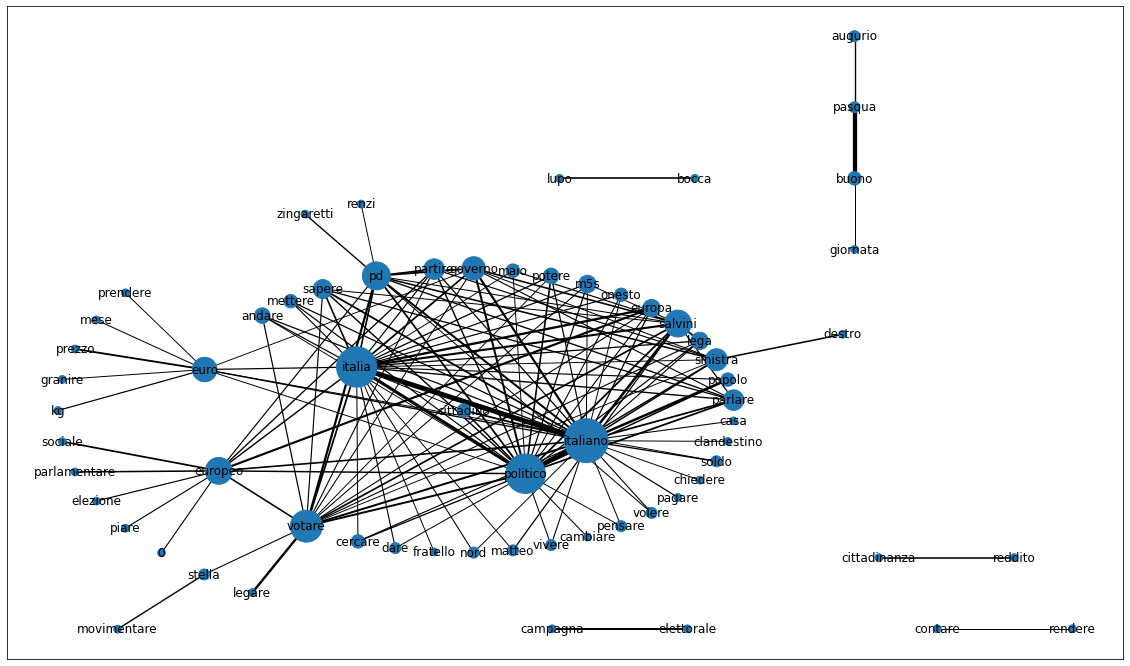

In [52]:
fig = plt.figure(figsize = (20,12))

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='twopi')
nx.draw_networkx(G, pos, width = list(weights), node_size = degrees)

# Threshold 200

In [53]:
edges_graph_thresh = edges_graph[edges_graph.iloc[:,2] >= 200]
edges_graph_thresh.columns= ['word1', 'word2', "weight"]



In [54]:
edges_graph_thresh = edges_graph_thresh.drop(edges_graph_thresh
                                             [((edges_graph_thresh.loc[:,'word1'].map(len) == 3) & 
                                               (edges_graph_thresh.loc[:,'word1'].map(lambda x: x[0]) == 'x'))|
                                              ((edges_graph_thresh.loc[:,'word2'].map(len) == 3) & 
                                               (edges_graph_thresh.loc[:,'word2'].map(lambda x: x[0]) == 'x'))].index)
edges_graph_thresh

word1        word2  weight
11056          casa     italiano     228
52243     cittadino       italia     201
52253     cittadino     italiano     396
52291     cittadino     politico     326
103451     politico      parlare     381
...             ...          ...     ...
948243      europeo        piare     240
948350      europeo            0     234
1285446  elettorale     campagna     431
1324048      stella  movimentare     296
1372371      pasqua      augurio     261

[140 rows x 3 columns]

In [65]:

G = nx.Graph()
G = nx.from_pandas_edgelist(edges_graph_thresh, source='word1', target='word2', edge_attr = "weight") 
weights = nx.get_edge_attributes(G,'weight').values()

weights = 10*np.array(list(weights))/max(weights)
degrees = [60*val for (node, val) in G.degree()]

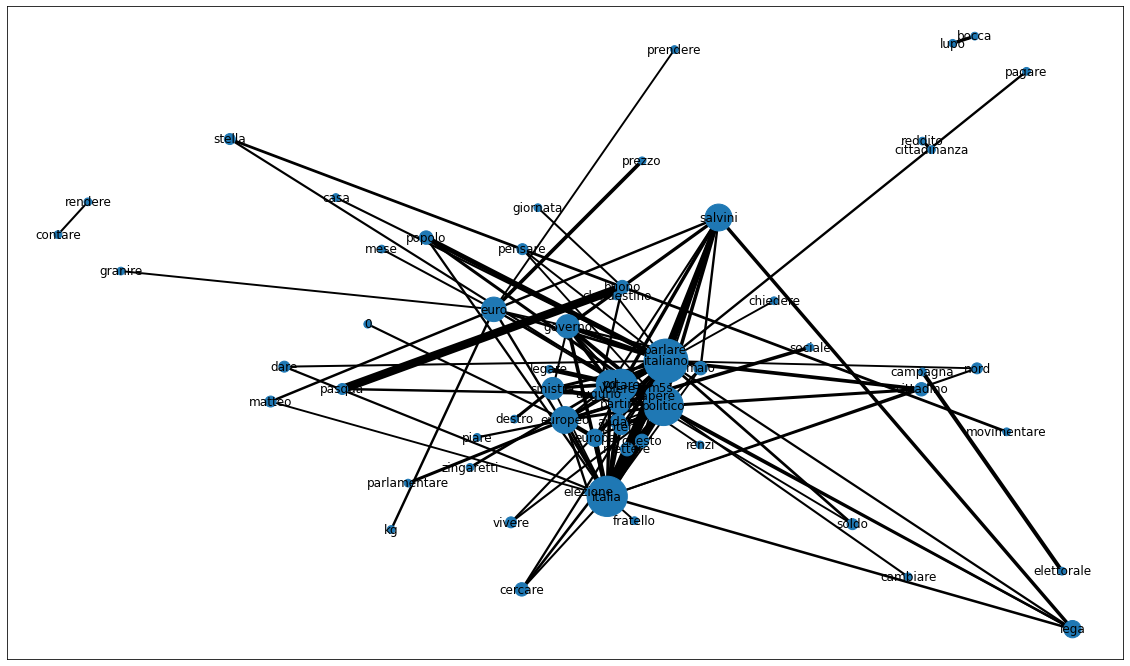

In [66]:
layout = nx.spring_layout(G, iterations = 5, seed = 7)

# layout = nx.draw_spectral(G)
fig = plt.figure(figsize = (20,12))
nx.draw_networkx(G, layout, width = list(weights), node_size = degrees)



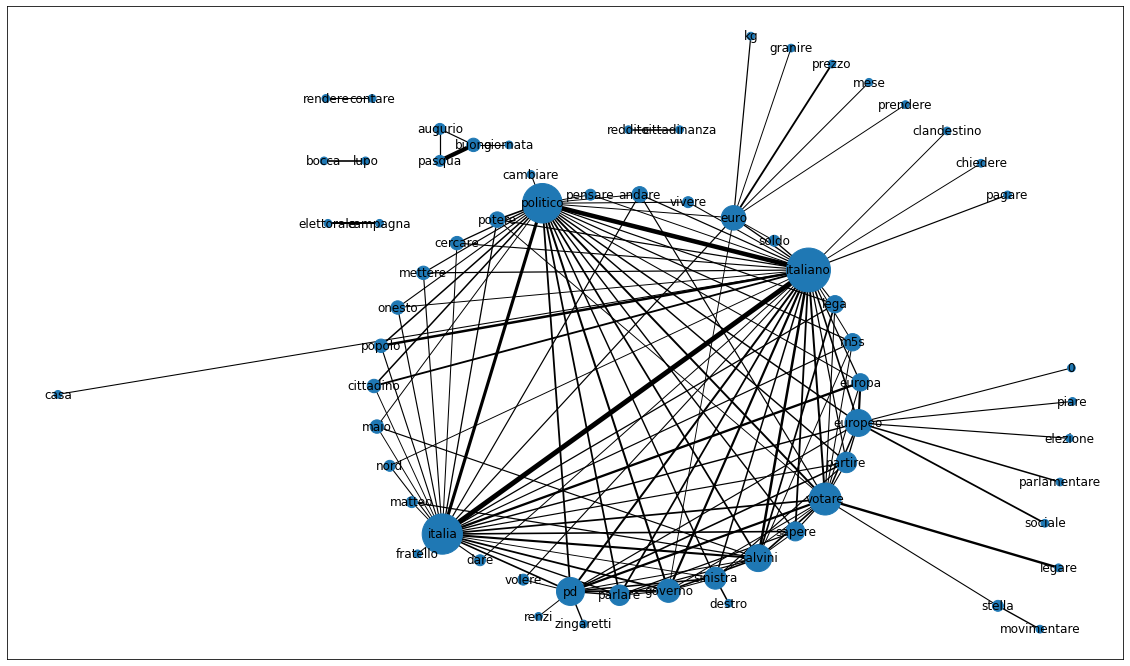

In [57]:
fig = plt.figure(figsize = (20,12))

pgv_Graph = nx.nx_agraph.to_agraph(G)
pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='circo')
nx.draw_networkx(G, pos, width = list(weights), node_size = degrees)


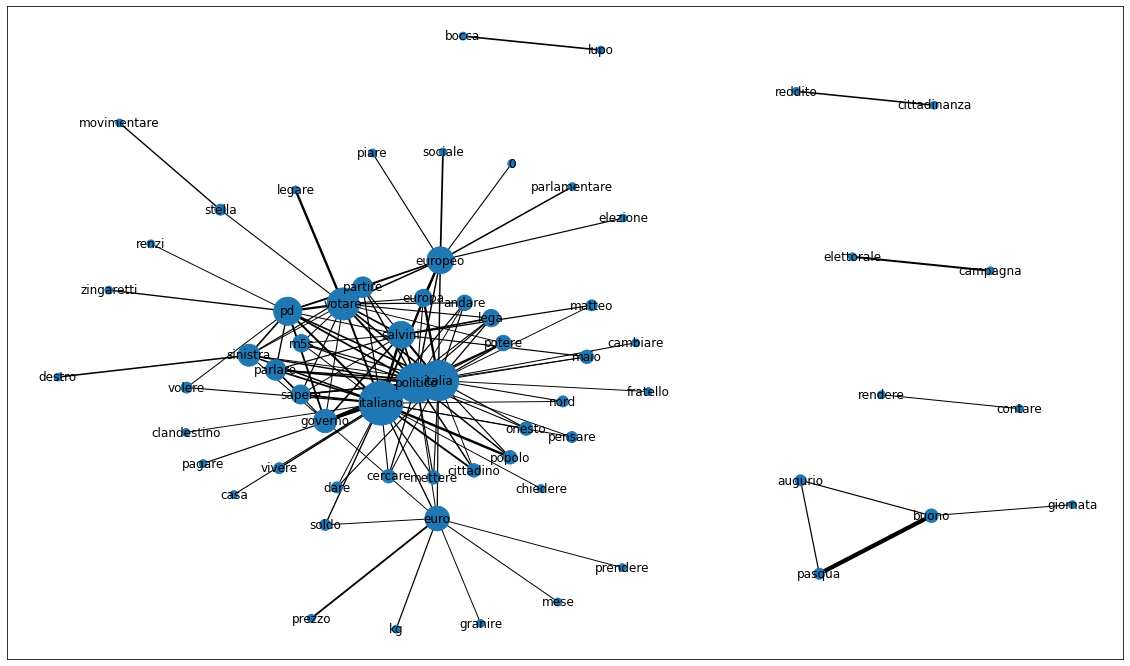

In [58]:
fig = plt.figure(figsize = (20,12))

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='neato')
nx.draw_networkx(G, pos, width = list(weights), node_size = degrees)

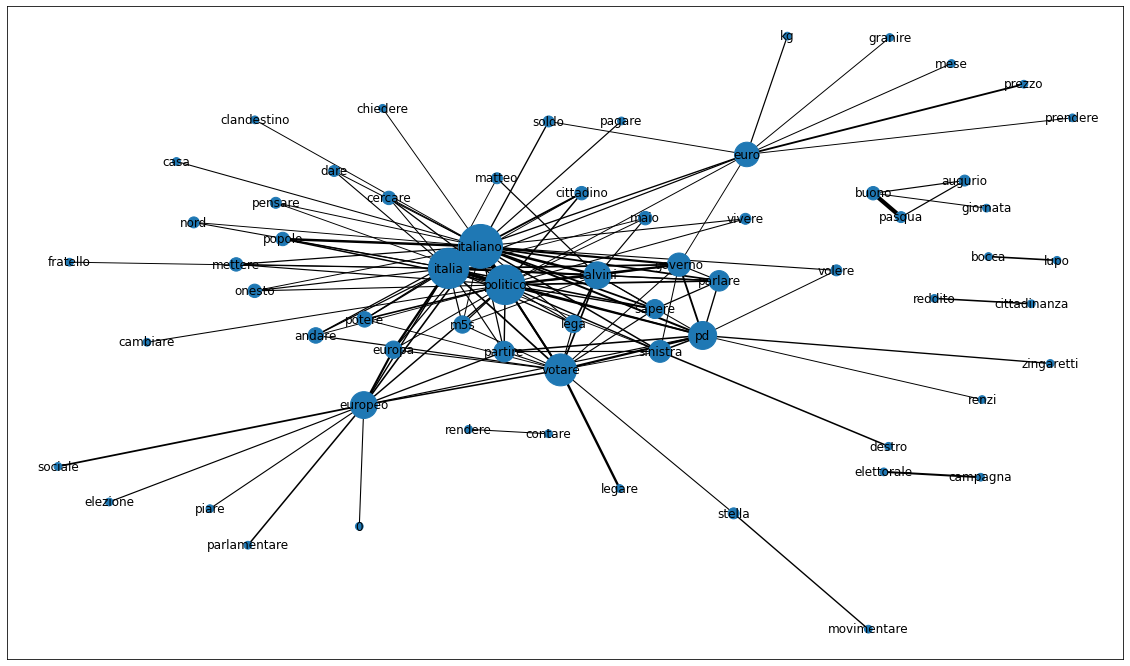

In [59]:
fig = plt.figure(figsize = (20,12))

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='fdp')
nx.draw_networkx(G, pos, width = list(weights), node_size = degrees)

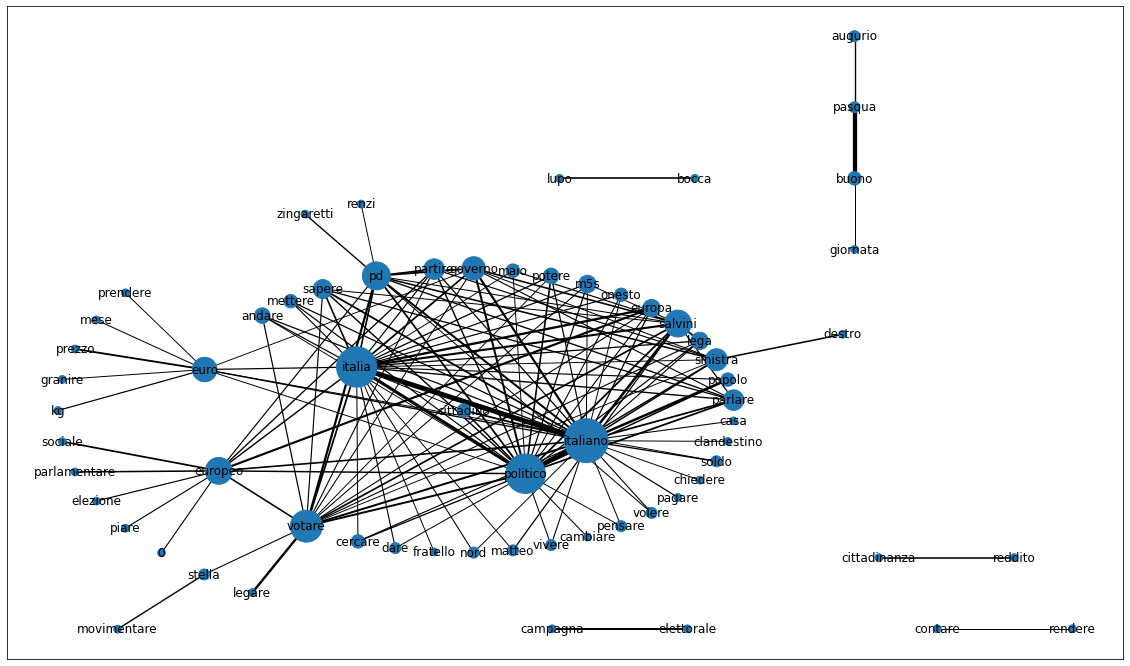

In [60]:
fig = plt.figure(figsize = (20,12))

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='twopi')
nx.draw_networkx(G, pos, width = list(weights), node_size = degrees)